
![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

  # Taller: Redes Neuronales

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de redes neuronales de una capa y multicapa. El taller está constituido por 4 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción probabilidad de admisión a la universidad

En este taller se usará el conjunto de datos de admisiones a una universidad proveniente de la base de datos de Kaggle. Cada observación contiene la probabilidad de que un estudiante sea admitido por la universidad, dadas distintas variables predictoras como el puntaje del examén TOEFL y GRE, el promedio (GPA), entre otras. El objetivo es predecir la probabilidad de admissión de cada estudiante. Para más detalles pueden visitar el siguiente enlace: [datos](https://www.kaggle.com/mohansacharya/graduate-admissions).

In [ ]:
!pip install livelossplot

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Importación librerías
import numpy as np
import keras
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from keras import initializers
from keras import optimizers
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Dropout

from livelossplot import PlotLossesKeras


# setup
plt.style.use('seaborn-v0_8')
plt.rcParams["figure.figsize"] = (5, 4)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('max_colwidth', None)

In [ ]:
from typing import Dict

# Metricas Modelos
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

def performance_regressor(
        y_true: np.array,
        y_pred: np.array,
        view_plot: bool=True,
        view_stats: bool=False
    )->Dict:
    """"""

    model_score: Dict = dict(
        r2=r2_score(y_true, y_pred),
        rmse=mean_squared_error(y_true, y_pred, squared=False),
        mse=mean_squared_error(y_true, y_pred),
        mae=mean_absolute_error(y_true, y_pred),
        mape=mean_absolute_percentage_error(y_true, y_pred)
    )

    if view_plot:
        df = pd.DataFrame({
            'predictions':y_pred,
            'residuals':y_true - y_pred,
            'real':y_true
        })

        fig, axes = plt.subplots(1, 2, squeeze=False, figsize=(10, 5))
        plot_params = {
            'x':'predictions',
            'data':df,
            'color':'black',
            'scatter_kws':{'alpha':0.3, 's':10}
        }

        sns.residplot(ax=axes[0, 0], y='residuals', **plot_params)
        sns.regplot(ax=axes[0, 1], y='real', **plot_params)

    if view_stats:
        for k, v in model_score.items():
            print(f'{k}:', v)

    return model_score

In [ ]:
# Carga de datos de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/universityGraduateAdmissions.csv', index_col=0)
data.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
Serial No.,,,,,,,,
1,337,118,4,4.5,4.5,9.65,1,0.92
2,324,107,4,4.0,4.5,8.87,1,0.76
3,316,104,3,3.0,3.5,8.00,1,0.72
4,322,110,3,3.5,2.5,8.67,1,0.80
5,314,103,2,2.0,3.0,8.21,0,0.65


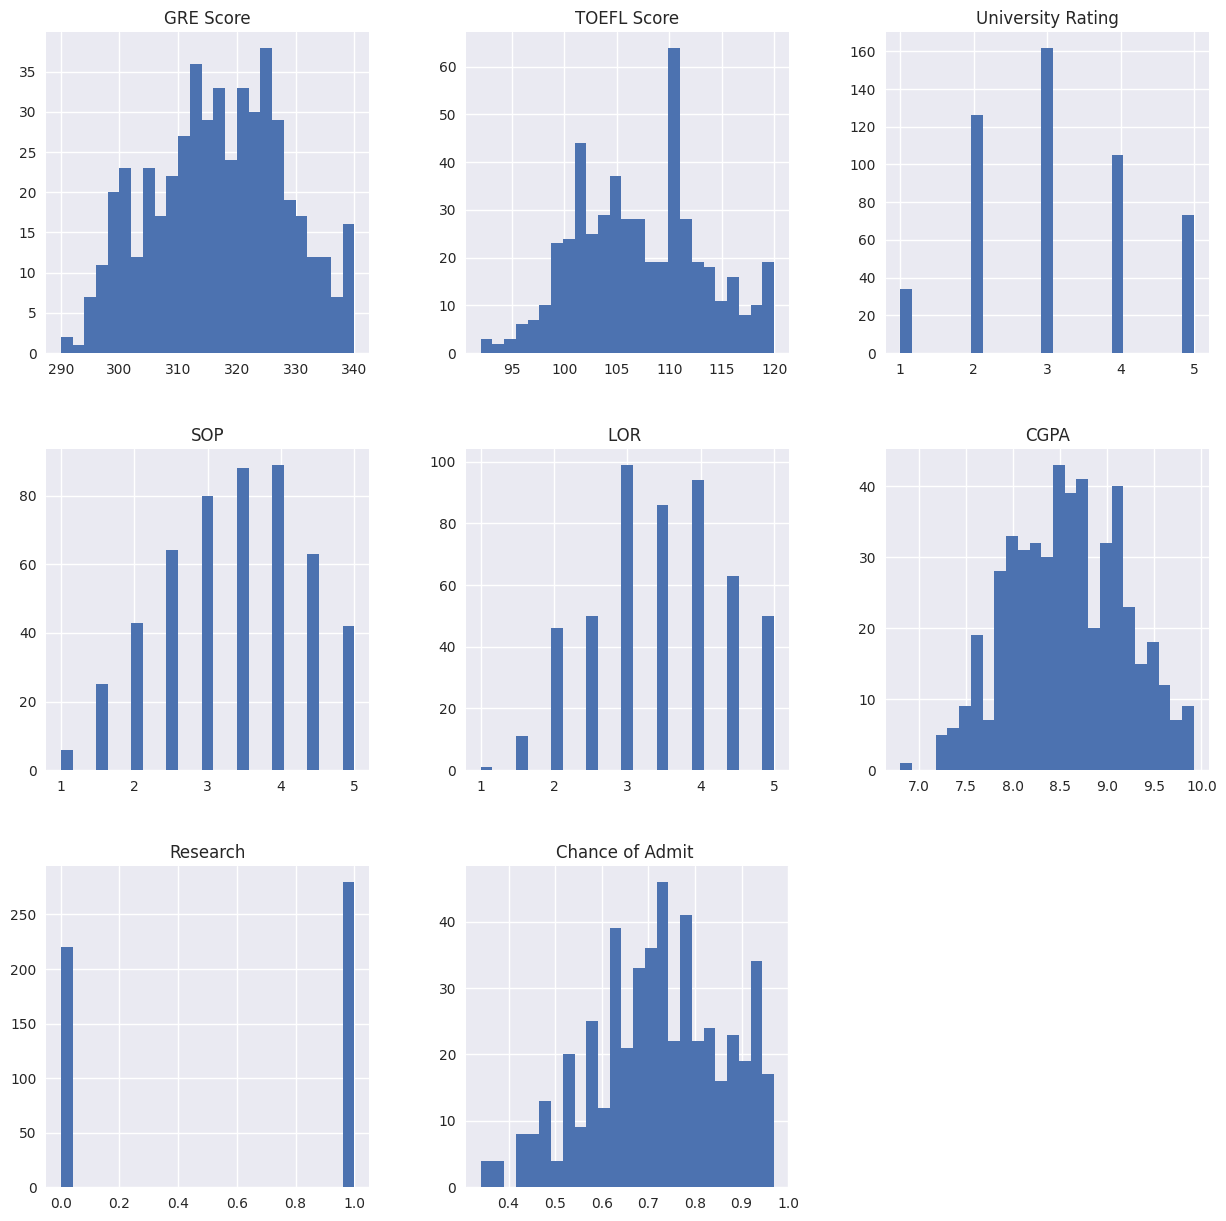

In [ ]:
# Hitogramas de las varaibles del dataset
data.hist(bins=25, figsize=(15,15))
plt.show()

In [ ]:
# Definición de variables predictoras (X)
X = data.drop(data.columns[-1], axis=1)
# Definición de variable de interés (y)
Y = data[data.columns[-1]]

In [ ]:
# Separación de variables predictoras (X) y variable de interés (y) en set de entrenamiento y test usandola función train_test_split
xTrain, xTest, yTrain, yTest = train_test_split(X,Y,test_size=0.3, random_state=22)

In [ ]:
# Separación de variables predictoras (X) y variable de interés (y) en set de final entrenamiento y validacion usandola función train_test_split
xTrain_f, xVal, yTrain_f, yVal = train_test_split(xTrain,yTrain,test_size=0.1, random_state=22)

In [ ]:
xTrain_f.describe()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
count,315.000000,315.000000,315.000000,315.000000,315.000000,315.000000,315.000000
mean,316.692063,107.406349,3.120635,3.392063,3.509524,8.592730,0.555556
std,11.463196,6.189159,1.144658,1.006872,0.904644,0.596915,0.497695
min,290.000000,92.000000,1.000000,1.000000,1.500000,7.210000,0.000000
25%,309.000000,103.000000,2.000000,2.500000,3.000000,8.130000,0.000000
50%,317.000000,107.000000,3.000000,3.500000,3.500000,8.570000,1.000000
75%,325.000000,112.000000,4.000000,4.000000,4.000000,9.040000,1.000000
max,340.000000,120.000000,5.000000,5.000000,5.000000,9.920000,1.000000


In [ ]:
yTrain_f.describe()

count    315.000000
mean       0.724317
std        0.139315
min        0.340000
25%        0.635000
50%        0.730000
75%        0.820000
max        0.970000
Name: Chance of Admit , dtype: float64

In [ ]:
# Normalización de variables predictoras (X) con la función StandardScaler
from sklearn.preprocessing import StandardScaler

# Definición de la función StandardScaler
scaler = StandardScaler()
scaler.fit(xTrain_f)


# Transformación de los set de entrenamiento y test
xTrain_f = pd.DataFrame(data=scaler.transform(xTrain_f), columns=xTrain.columns, index=xTrain_f.index)
xTest = pd.DataFrame(data=scaler.transform(xTest), columns=xTest.columns, index=xTest.index)
xVal = pd.DataFrame(data=scaler.transform(xVal), columns=xVal.columns, index=xVal.index)

xTrain_f = np.array(xTrain_f)
yTrain_f = np.array(yTrain_f)

xVal = np.array(xVal)
yVal = np.array(yVal)

xTest = np.array(xTest)
yTest = np.array(yTest)

In [ ]:
yTrain.shape

(350,)

In [ ]:
# Definición de dimensiones de salida, varaibles de interés
output_var = 1
print(output_var, ' output variables')

# Definición de dimensiones de entrada, varaibles predictoras
dims = xTrain_f.shape[1]
print(dims, 'input variables')

1  output variables
7 input variables


In [ ]:
# Reproducibility in Keras Models
# https://keras.io/examples/keras_recipes/reproducibility_recipes/
keras.utils.set_random_seed(22)

## Punto 1 - Red Neuronal de una capa

En la celda 1 creen una **red neuronal de una capa** con la librería Keras, que prediga la probabilidad de admisión de los estudiantes, usando los sets de entrenamiento y test definidos anteriormente. Pueden usar la función de perdida, el optimizador y el número de épocas que consideren pertinentes para el modelo, justificando su selección. Finalmente, grafiquen la pérdida del modelo vs el número de épocas en el set de entrenamiento y validación, y presenten el desempeño del modelo con las métricas error absoluto medio (MAE) y error cuadrático medio (MSE).

In [ ]:
# Celda 1
# Definición red neuronal con la función Sequential()
model = Sequential()
# Definición de la capa densa con un tamaño de salida igual a output_var y un input_shape de dims
model.add(Dense(output_var, input_shape=(dims,), activation='sigmoid'))

# Impresión de la arquitectura de la red neuronal
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1)                 8         
                                                                 
Total params: 8 (32.00 Byte)
Trainable params: 8 (32.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
# Definición de función de perdida. Se usa mean_squared_error dado que es un ejercicio de regresión
model.compile(optimizer='adam', loss='mean_squared_error')

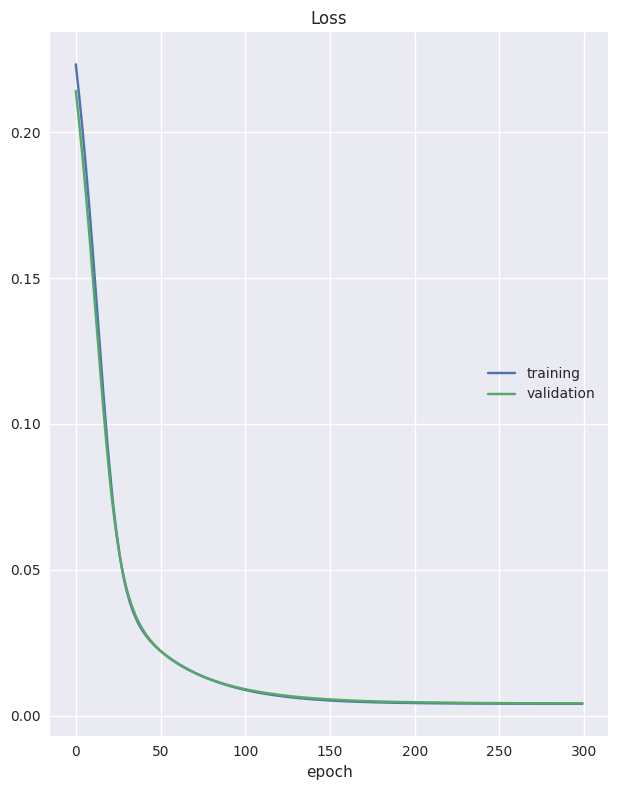

Loss
	training         	 (min:    0.004, max:    0.223, cur:    0.004)
	validation       	 (min:    0.004, max:    0.214, cur:    0.004)
10/10 [==============================] - 0s 40ms/step - loss: 0.0041 - val_loss: 0.0043


In [ ]:
# Entrenamiento de la red neuronal con 300 épocas
model.fit(
    xTrain_f, yTrain_f,
    verbose=1,
    epochs=300,
    validation_data=(xVal, yVal),
    callbacks=[PlotLossesKeras()]
)

5/5 [==============================] - 0s 3ms/step
MSE: 0.0033548854806487514
MAE: 0.044051477909088144


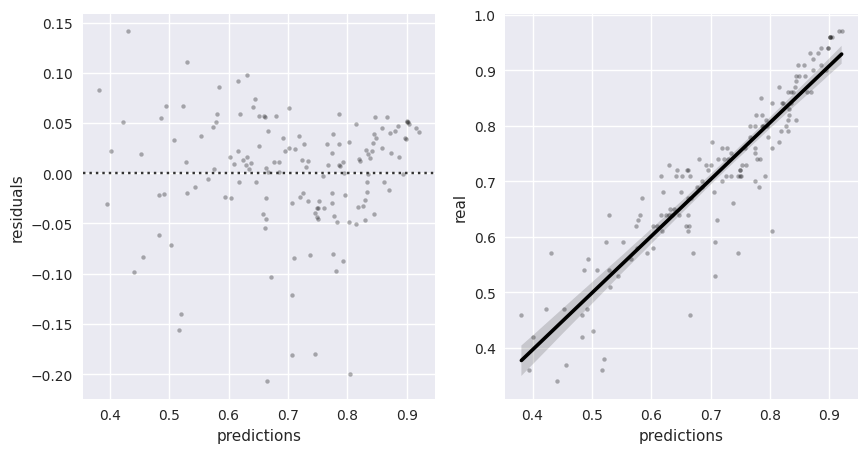

In [ ]:
y_pred = model.predict(xTest)
metrics_one_layer_p1 = \
    performance_regressor(yTest, y_pred.ravel())

mse = metrics_one_layer_p1.get('mse')
mae = metrics_one_layer_p1.get('mae')

print(f'MSE: {mse}')
print(f'MAE: {mae}')

Como se puede ver usando una red neuronal de una capa se obtiene un mse de 0.0033 y un mae de 0.0439 lo que indica que el modelo esta teniendo un muy buen desempeño considerando que estos valores son menores que la media de la variable predictora (0.72) y su desviacion (0.13)

El MSE es una metrica que mide el promedio de los cuadrados de las diferencias entre los valores predichos y los valores reales. Un MSE más bajo indica un mejor ajuste del modelo a los datos. El MAE por otro lado es la media de las diferencias absolutas entre las predicciones del modelo y los valores reales.

En cuanto a la grafica de perdida se puede ver que la grafica empieza a disminuir en menor medida a partir del periodo 100 mas o menos y que converge y se estabiliza a partir de la 300 aproximadamente lo que quiere decir que el modelo ya no mejorara significativamente su rendimiento, adicionalmente la perdida en validacion y entrenamiento es 0.0041 y 0.0043 respectivamente, para la función de perdida `mean_squared_error` estos valores indican que el modelo esta haciendo buenas prediciones pues la perdida es bastante baja.

La gráfica muestra una disminución consistente y suave de la pérdida tanto en el conjunto de entrenamiento como en el de validación a lo largo de las epocas,  indica un buen aprendizaje del modelo sin signos de sobreajuste, la convergencia de las líneas de pérdida sugiere que el modelo generaliza bien a datos no vistos, el hecho de que las curvas de pérdida de entrenamiento y validación al final sean tan cercanas sugiere que el modelo no está memorizando los datos, sino generalizando bien.[1]

Se utilizó en un primero momento el optimizador SGD (Stochastic Gradient Descent), al igual que el descenso de gradiente estándar, el SGD actualiza iterativamente los pesos de la red neuronal para minimizar la función de pérdida. Para cada paso de entrenamiento, calcula el gradiente de la función de pérdida con respecto a los pesos y ajusta los pesos en la dirección opuesta al gradiente.
SGD: " Es un enfoque popular entre los optimizadores en el aprendizaje profundo. El término "estocástico" denota el elemento de aleatoriedad en el que se basa el algoritmo. En el descenso de gradiente estocástico, en lugar de procesar todo el conjunto de datos durante cada iteración, seleccionamos lotes de datos al azar. Esto implica que solo se consideran unas pocas muestras del conjunto de datos a la vez, lo que permite una optimización más eficiente y computacionalmente factible en los modelos de aprendizaje profundo."[2]

No obstante lo anterior, se eligió el optimizador `Adam` debido a su eficiencia en problemas con múltiples variables que interactúan de maneras complejas (se tienen 4 variables categóricas y 3 variables numéricas). Además, la facilidad de uso y menor necesidad de ajustes finos para este caso. se realizan pruebas y 'adam' da metricas mas bajas que `sgd`[3]

En cuanto a la función de activación se debe hacer la seleccion adecuada con el fin de mejorar los resultados de la red neuronal. Por lo tanto en este caso se uso la funcion ReLU (Rectified Linear Unit), ya que hace parte de las funciones no lineales las cuales son conocidas por ser las funciones de activación más utilizadas. Facilitan que un modelo de red neuronal se adapte a una variedad de datos y diferencie entre los resultados, una ventaja de esta funcion es no activa todas las neuronas al mismo tiempo, lo que la hace mucho más eficiente computacionalmente en comparación con las funciones sigmoide y la funcion Tanh.[4][5]

Asimismo al probar esta función ReLU (Rectified Linear Unit) versus la que viene por defecto en la Clase `keras.layer.Dense` (`a(x) = x`), se observa que una activación lineal calibra para este caso mejor la red neuronal de una capa, esto puede deberse a que los valores de salida (a predecir) son siempre positivos aunado al hecho que no poseen outliers al estar comprendido entre `0 y 1`.

De otro lado se empleó la función de activación Sigmoid, donde se evidenció que se obtenia un MSE mejor que la función de activación lineal mientras que en esta última el MAE era mejor. Dado que la gráfica de real vs predicho no se evidencia homocedasticidad, un indicador como el MAE podría resultar engañoso (promedio de las desviaciones), por lo que el MSE, al penalizar las desviaciones en este caso de heterocedasticidad, resultaria más fiable, es por ello que nos decantarnos al final por la Función activacion Sigmoid.

Para la funcion de perdida dado que es un ejercicio de regresion se considero usar el MSE ya que al entrenar con error cuadrático medio el modelo tienen menos valores atípicos o al menos valores atípicos menos graves que los modelos entrenados con error absoluto medio (MAE), porque el MSE prioriza una gran cantidad de pequeños errores sobre unos pocos errores grandes.[4]

Teniendo en cuenta estos parametros y que los resultados obtenidos a partir de estos dieron como resultado un modelo con buen desempeño, se usaran estos parametros en los siguientes puntos con el fin de comparar los resultados.

- [1] [Why is my validation loss lower than my training loss?](https://pyimagesearch.com/2019/10/14/why-is-my-validation-loss-lower-than-my-training-loss/)

- [2] [A Comprehensive Guide on Optimizers in Deep Learning](https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-on-deep-learning-optimizers/)
    
    [What is Adam Optimizer?](https://www.analyticsvidhya.com/blog/2023/09/what-is-adam-optimizer/)
    
    [Complete Guide to the Adam Optimization Algorithm](https://builtin.com/machine-learning/adam-optimization)
    
    [Optimizers](https://keras.io/api/optimizers/)


- [3] [Fundamentals of Deep Learning – Activation Functions and When to Use Them?](https://www.analyticsvidhya.com/blog/2020/01/fundamentals-deep-learning-activation-functions-when-to-use-them/)
- [4] [Activation Functions Neural Networks A Quick & Complete Guide](https://www.analyticsvidhya.com/blog/2021/04/activation-functions-and-their-derivatives-a-quick-complete-guide/)

- [5] [Basic Introduction to Loss Functions](https://www.analyticsvidhya.com/blog/2022/08/basic-introduction-to-loss-functions/)

## Punto 2 - Red Neuronal multicapa

En la celda 2 creen una **red neuronal con dos capas** con la librería Keras, que prediga la probabilidad de admisión de los estudiantes usando los sets de entrenamiento y test definidos anteriormente. Pueden usar la función de perdida, el optimizador, el número de épocas y el número de neuronas que consideren pertinentes para el modelo, justificando su selección. Finalmente, grafiquen la pérdida del modelo vs el número de épocas en el set de entrenamiento y validación, y presenten el desempeño del modelo con las métricas error absoluto medio (MAE) y error cuadrático medio (MSE).

In [ ]:
# Celda 2
K.clear_session()

# Definición red neuronal con la función Sequential()
model2 = Sequential()

# Definición de la capa densa con un tamaño de salida igual a output_var y un input_shape de dims
model2.add(Dense(64, input_shape=(dims,), activation='relu'))
model2.add(Dense(output_var, activation='sigmoid'))

# Impresión de la arquitectura de la red neuronal
print(model2.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                512       
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 577 (2.25 KB)
Trainable params: 577 (2.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
# Definición de función de perdida. Se usa mean_squared_error dado que es un ejercicio de regresión
model2.compile(optimizer='adam', loss='mean_squared_error')

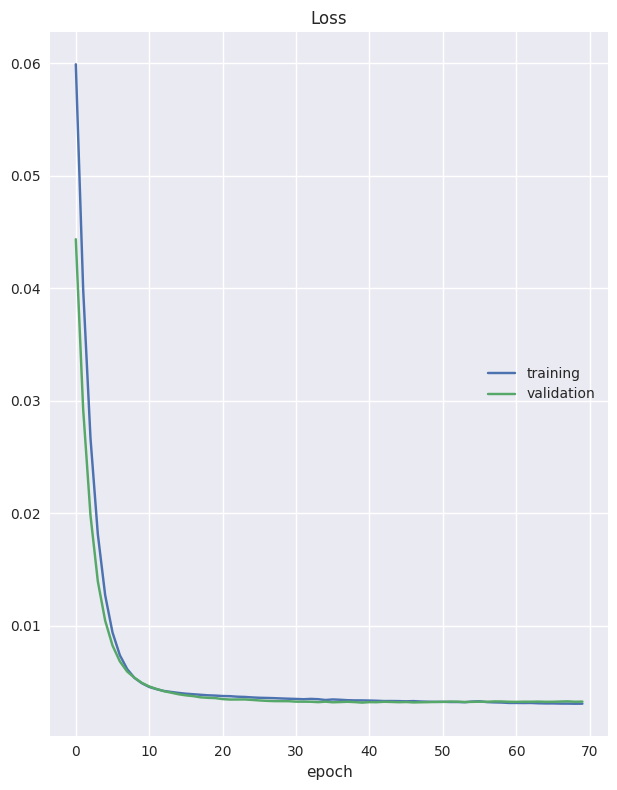

Loss
	training         	 (min:    0.003, max:    0.060, cur:    0.003)
	validation       	 (min:    0.003, max:    0.044, cur:    0.003)
10/10 [==============================] - 0s 50ms/step - loss: 0.0031 - val_loss: 0.0032


In [ ]:
# Entrenamiento de la red neuronal con 40 épocas
model2.fit(
    xTrain_f, yTrain_f,
    verbose=1,
    epochs=70,
    validation_data=(xVal, yVal),
    callbacks=[PlotLossesKeras()]
)

5/5 [==============================] - 0s 2ms/step
MSE: 0.003875446203289575
MAE: 0.04531962775389353


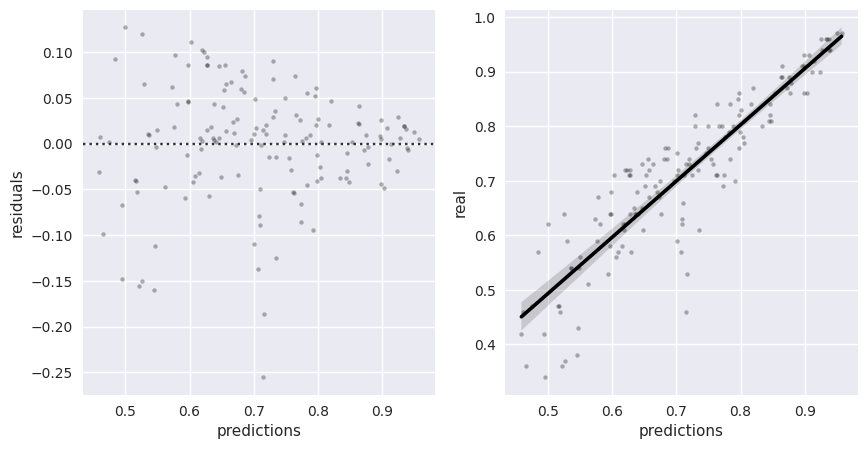

In [ ]:
y_pred = model2.predict(xTest)
metrics_multi_layer_p2 = \
    performance_regressor(yTest, y_pred.ravel())

mse_multi = metrics_multi_layer_p2.get('mse')
mae_multi = metrics_multi_layer_p2.get('mae')

print(f'MSE: {mse_multi}')
print(f'MAE: {mae_multi}')

Usando los mismos parámetros que la red de una capa se observan los siguientes resultados (téngase en cuenta que la función de activación de entrada sí es relu, mientras que la de salida es sigmoid, siendo esta última igual a la de una capa):

De los resultados de la muestra de entrenamiento y validacion usando el MSE como funcion de perdida en la grafica se puede observar que empieza a disminuir en menor medida a partir del periodo 5 mas o menos, mientras que en la epoca 50 aproximadente la grafica converge es decir que aunque se realice entrenamiento adicional el desempeño del modelo no mejorara significativamente, sin embargo comparandolo con el modelo que una capa se puede observar que la convergancia se alcanzo más rápido, en este caso los resultado obetnido para la perdida en validacion y entrenamiento fueron 0.0030 y 0.0031 respectivamente que aunque en validacion es ligeramente mas alto sigue significando un buen desempeño pues los valores de perdida son bajos

En cuanto al desempeño en la data de Test se obtiene un mse de 0.0035 y un mae de 0.0434, lo que implica tambien que el modelo esta teniendo un buen desempeño a la hora de realizar predicciones en data que no habia "visto" antes pues se obtuvieron valores menores que la media y la desviacion de la variable predictora 0.72 y 0.13 respectivamente.

El MSE es una métrica que mide el promedio de los cuadrados de las diferencias entre los valores predichos y los valores reales. Un MSE más bajo indica un mejor ajuste del modelo a los datos. El MAE por otro lado es la media de las diferencias absolutas entre las predicciones del modelo y los valores reales.

Asimismo la adición de una segunda capa tiene las siguientes consideraciones

Una red más profunda puede capturar mejor la complejidad de los datos, pero también puede requerir ajustes más finos en términos de la tasa de aprendizaje y otros hiperparámetros para estabilizar el entrenamiento.

Con más parámetros para aprender, el modelo puede comenzar a memorizar los datos de entrenamiento en lugar de aprender representaciones generalizables, lo cual podría explicar por qué las curvas empezaron a separarse y volverse erráticas después de cierto punto (de la época 20 hasta la época 50).

A pesar de ser un modelo mas complejo, no mejora las metricas.

## Punto 3  - Red Neuronal multicapa

En la celda 3 creen **una red neuronal con más de una capa con la librería Keras, usando early stopping y dropout,** que prediga la probabilidad de admisión de los estudiantes con los sets de entrenamiento y test definidos anteriormente. Pueden usar la función de perdida, el optimizador, el número de épocas y el número de neuronas que consideren pertinentes para el modelo, justificando su selección. Finalmente, grafiquen la pérdida del modelo vs el número de épocas en el set de entrenamiento y validación, y presenten el desempeño del modelo con las métricas error absoluto medio (MAE) y error cuadrático medio (MSE).

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2

In [ ]:
# Celda 3
K.clear_session()

# Definición red neuronal con la función Sequential()
model3 = Sequential()

# Definición de la capa densa con un tamaño de salida igual a output_var y un input_shape de dims
model3.add(Dense(128, input_shape=(dims,), activation='relu', kernel_regularizer=l2(0.01)))
model3.add(Dropout(0.2))

model3.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model3.add(Dropout(0.2))

model3.add(Dense(output_var, activation='sigmoid'))

# Definición de función de perdida. Se usa mean_squared_error dado que es un ejercicio de regresión
model3.compile(optimizer='adam', loss='mean_squared_error')

# Impresión de la arquitectura de la red neuronal
print(model3.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1024      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9345 (36.50 KB)
Trainable params: 9345 (36.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
# Definición de la función EarlyStopping para considerar durante el entrenamiento
early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1, restore_best_weights=True)

# Definición de la función ModelCheckpoint para guardar el modelo con mejor desempeño
fBestModel = 'best_model.keras'
best_model = ModelCheckpoint(fBestModel, verbose=0, save_best_only=True)

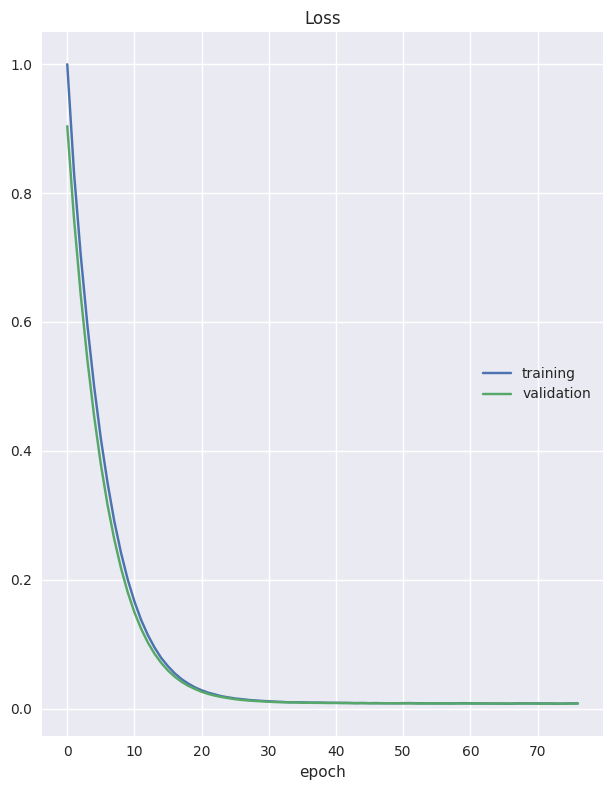

Loss
	training         	 (min:    0.007, max:    1.000, cur:    0.008)
	validation       	 (min:    0.007, max:    0.904, cur:    0.008)
10/10 [==============================] - 0s 44ms/step - loss: 0.0079 - val_loss: 0.0077
Epoch 77: early stopping


In [ ]:
# Entrenamiento de la red neuronal con 60 épocas y early stopping
model3.fit(
    xTrain_f, yTrain_f,
    verbose=1,
    epochs=200,
    validation_data=(xVal,yVal),
    callbacks=[best_model, early_stop, PlotLossesKeras()]
)

5/5 [==============================] - 0s 3ms/step
MSE: 0.004095290962559752
MAE: 0.04889493699073792


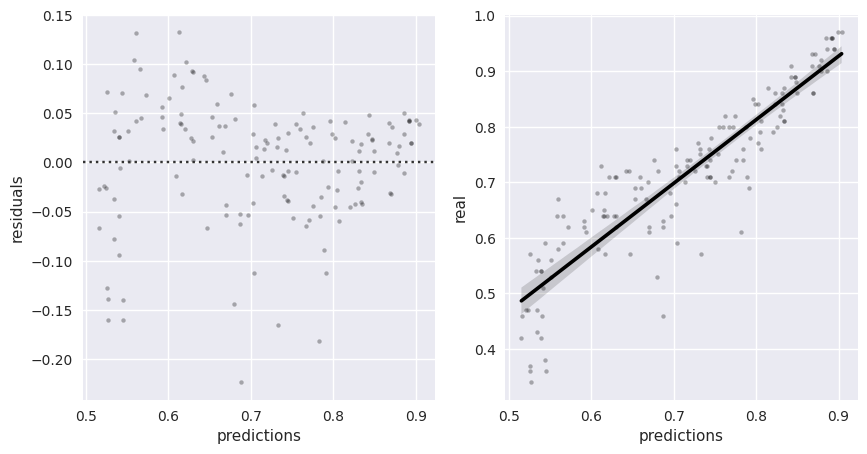

In [ ]:
y_pred = model3.predict(xTest)
metrics_multi_layer_p3 = \
    performance_regressor(yTest, y_pred.ravel())

mse_stop = metrics_multi_layer_p3.get('mse')
mae_stop = metrics_multi_layer_p3.get('mae')

print(f'MSE: {mse_stop}')
print(f'MAE: {mae_stop}')

El modelo inicia caotico al inicio lineas de entrenamiento y validacion separadas y ruido intenso, despues de diferentes ajustes a los hiperparametros se logra estabilizar y se reitera que entre mas capas tiene una red neuronal mas detalles finos tienen que existir para controlar todo este andamiaje, desafortunadamente no hay una mejora que justifique un modelo mas complejo, al parecer la prediccion de la probabiliad de estudiantes admitidos y este conjunto de datos en particular  no amerita un modelo tan complejo.

Explicación de los Cambios


Activación relu para las 2 capas iniciales que es comúnmente usada en las capas ocultas de las redes neuronales debido a su capacidad para modelar no linealidades y su eficiencia computacional.

Activación sigmoid: Se mantiene la sigmoid en la capa de salida para asegurar que la salida del modelo esté entre 0 y 1, lo que es adecuado si el objetivo es predecir una probabilidad.

L2(0.01) aplica la regularización L2 a los pesos de las capas densas con un coeficiente de regularización, esto significa que durante el entrenamiento, no solo se minimiza la pérdida original (mean squared error), sino también la suma de los cuadrados de los pesos de estas capas, multiplicada por 0.01, este enfoque ayuda a prevenir el sobreajuste, especialmente útil en redes profundas o en situaciones donde la cantidad de datos puede no ser muy grande en comparación con el número de parámetros del modelo.

se ha aplicado Dropout después de cada capa densa antes de la capa de salida,  significa que durante cada iteración de entrenamiento, el 20% de las neuronas en cada una de estas capas son aleatoriamente ignoradas (no se actualizan durante el paso de retropropagación), esto ayuda a asegurar que el modelo no dependa demasiado de ninguna entrada particular, y mejora la habilidad del modelo para generalizar bien a nuevos datos.

En las primeras capas de la red, especialmente en redes profundas, hay una tendencia a tener más neuronas para capturar una amplia variedad de características del input, a medida que avanza hacia las capas posteriores, el objetivo se inclina más hacia la consolidación de estas características en aspectos más útiles y significativos para la tarea de predicción, es por esto que la primera red se ajusta con 128 y la segunda con 64. Reducir el número de neuronas en capas sucesivas puede ayudar a minimizar el riesgo de sobreajuste, con menos parámetros para ajustar en las capas más profundas, la red puede ser forzada a aprender representaciones más robustas y generalizables de los datos.

El Early Stopping es esencialmente una forma de regularización utilizada para evitar el sobreajuste, especialmente en situaciones donde un modelo se entrena durante un número indeterminado de épocas. Actúa como una red de seguridad que detiene el entrenamiento si no hay signos de progreso en el aprendizaje, basándose en la métrica especificada (en este caso, la pérdida de validación). Esto no solo previene el sobreajuste sino que también puede ahorrar tiempo y recursos computacionales al evitar entrenamientos innecesariamente largos. parametros ajustados:

monitor='val_loss': este parámetro especifica qué métrica el callback debería monitorear, en este caso, val_loss se refiere a la pérdida en el conjunto de validación.

patience=5: Define el número de épocas para continuar el entrenamiento después de que se detecte por última vez una mejora en la métrica monitorizada, dado que se utilizaron 200 epocas este parametro sirve para evitar el sobreajuste equilibrar estos 2 aspectos

mode='min': indica que el proceso de Early Stopping debe detenerse cuando la métrica monitorizada ha dejado de disminuir (minimizando la pérdida), asegura que el Early Stopping se activará si val_loss no disminuye; es decir, busca el mínimo de val_loss

restore_best_weights=True:este parámetro decide si restaurar o no los pesos del modelo desde la época en la que se observó el mejor valor de la métrica monitorizada. Garantiza que aunque el entrenamiento pueda continuar durante varias épocas después de alcanzar el mínimo de pérdida de validación, el modelo regresará a los pesos que tenían el mejor rendimiento en términos de val_loss, lo cual es crucial para tener un modelo que generalice bien.

El modelo muestra un desempeño consistente tanto en el conjunto de entrenamiento como en el de validación, la función de pérdida se reduce significativamente en las primeras épocas, lo cual es indicativo de un buen aprendizaje inicial, la convergencia de las líneas de pérdida indica que el modelo no está sobreajustando significativamente.

La implementación de regularizaciones L2 y Dropout parece estar ayudando a controlar el sobreajuste, como se puede observar por la estabilidad en las curvas de pérdida a lo largo de las épocas, esto tambien se refleja en el hecho de que el modelo se detiene temprano (early stopping) en la época 43, sugiriendo que no se observan mejoras sustanciales después de este punto.

En términos de métricas, el MAE y el MSE son relativamente bajos pero levemente superiores a modelos anteriores, indicando que el modelo tiene un error medio y medio cuadrático bajo en sus predicciones. El RMSE  también es bajo, lo que confirma la precisión del modelo en las predicciones de probabilidad de admisión. Esto significa que el modelo está realizando predicciones cercanas a los valores reales, y que generalmente es confiable en este contexto.

Las metricas son las mas altas entre los 3 modelos, a pesar de la complejidad.

## Punto 4 - Comparación y análisis de resultados

En la celda 4 comparen los resultados obtenidos de las diferentes redes y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

In [ ]:
# Celda 4
def plot_barh(df, title, xlabel, asc=False):
  ax = (
      df
      .sort_values(by='ejeY', ascending=asc)
      .plot(
          kind='barh', y='ejeY', x='ejeX', color='dodgerblue',
          title=title,
          xlabel=xlabel,
          ylabel=''
      )
  )
  ax.bar_label(ax.containers[0])
  plt.show()

ejeX = ['Red Una Capa', 'Red Multicapa','Red Multicapa Early Stopping']

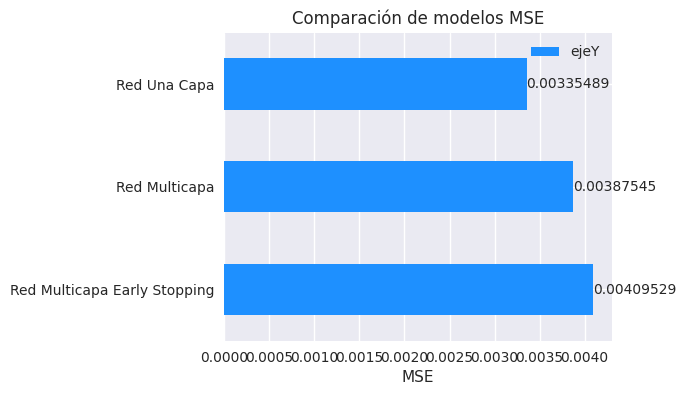

In [ ]:
plot_barh(
    df=pd.DataFrame({'ejeX': ejeX, 'ejeY': [mse, mse_multi, mse_stop]}),
    title='Comparación de modelos MSE',
    xlabel='MSE'
)

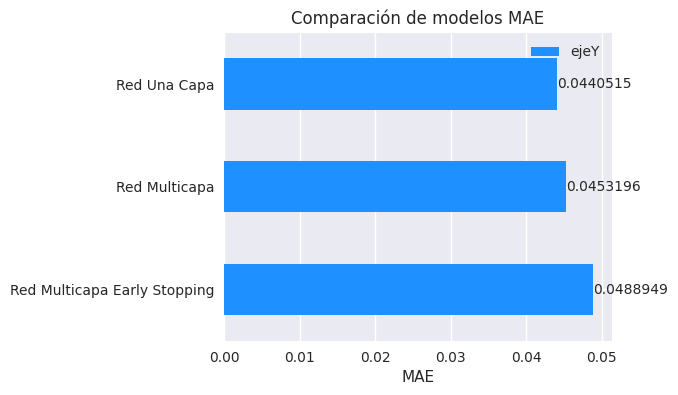

In [ ]:
plot_barh(
    df=pd.DataFrame({'ejeX': ejeX, 'ejeY': [mae, mae_multi, mae_stop]}),
    title='Comparación de modelos MAE',
    xlabel='MAE'
)

Teniendo en cuenta los resultados obtenidos se puede observar que el modelo con la red de una capa presento un mejor desempeño con respecto a los modelos multicapa

### Ventajas del Modelo de una capa:
Algunas de las ventajas que tienen estos modelos es su simplicidad pues un modelo de una capa es conceptualmente mas simple y requiere menos recursos computacionales para entrenar y probar el modelo, por lo que puede ser una buena eleccion para tareas relativamente sencillas, adicionalmente otra de sus ventajas es la velocidad de entrenamiento ya que al haber menos parametros de pesos que actualizar el modelo de una capa puede converger mas rapido, finalmente otra ventaja es la interpretabilidad pues en algunos caso es mas facil entender el rol de cada neurona cuando hay pocas capas que considerar [6]

### Desventajas del Modelo Multicapa early stopping:
Algunas de las desventajas de los modelos multicapa son la complejidad pues estos modelos suelen ser mas complejos en terminos de arquitectura y entrenamiento pues pueden requerir mas recursos computacionales para entrenar efectivamente, otra desventaja es que el entrenamiento es mas lento pues pueden llevar mas tiempo en converger y pueden llegar a ser mas suceptibles a quedarse atascados en un minimo local durante la optimizacion. Adicionalmente estos modelos pueden ser propensos a hacer overfitting si el modelo no esta bien regularizado o si la data de entrenamiento es muy pequeña[6]. En cuanto al early stopping esta "depende de la elección de la métrica y del parámetro de paciencia, que puede afectar al rendimiento y la convergencia del modelo. Además, puede ser sensible al ruido o a las fluctuaciones en los datos o la métrica de validación, lo que puede provocar una detención prematura o retrasada del entrenamiento. Por último, puede ser difícil determinar el punto óptimo de parada, ya que puede haber múltiples mínimos o máximos locales en la curva de validación."[7]

### Conclusiones
El incremento en la complejidad del modelo no siempre conduce a un mejor rendimiento, esto puede suceder si las capas adicionales no están capturando patrones útiles, modelos más complejos requieren ajustes más finos y sutiles para su posterior mantenimiento (re-entrenamiento).

Dado el tipo de datos (tabular) y considerando que la dimensión no es grande (7 viables predictoras) y las características parecen tener una naturaleza más tradicional (puntajes de exámenes, evaluaciones, y un componente categórico de investigación), modelos como XGBoost o basados en arboles podrían ser muy efectivos y, en algunos casos, preferibles a las redes neuronales que requieren un diseño cuidadoso de la arquitectura y el ajuste de muchos otros parámetros (como el número de capas, número de neuronas por capa, tasas de dropout, etc.

[6] [What are the advantages and disadvantages of using a single hidden layer with many units in an artificial neural network compared to using multiple layers with fewer units each?](https://www.quora.com/What-are-the-advantages-and-disadvantages-of-using-a-single-hidden-layer-with-many-units-in-an-artificial-neural-network-compared-to-using-multiple-layers-with-fewer-units-each)

[7] [¿Qué es la detención temprana y cómo mejora la optimización del aprendizaje profundo?](https://www.linkedin.com/advice/0/what-early-stopping-how-does-improve-deep-5mn1e)

